# Offline batch Q-Learning: linear layer
In this part, a random policy is used to learn. 2000 episdoes are recorded and used to train Q-network weights

# Running this file
Run the first two cells and proceed as instucted


In [7]:
import sys
import math
import random
import pdb
import numpy as np
import tensorflow as tf
import gym
import time
import warnings
import matplotlib.pyplot as plt
import matplotlib
import os
warnings.filterwarnings('ignore')

In [8]:
# create a network that  will be used to take the loss.
def create_network(state, action, next_state, reward, hidden, alpha, n_hidden=100, discount=0.99):

    if hidden == True:
        weights = {'w1': tf.Variable(tf.random_uniform([4, n_hidden], 0, 0.01)),
                   'w2': tf.Variable(tf.random_uniform([n_hidden, 2], 0, 0.01))}
        biases = {'b1': tf.Variable(tf.random_uniform([n_hidden], 0, 0.01)),
                  'b2': tf.Variable(tf.random_uniform([2], 0, 0.01))}

        hidden = tf.nn.relu(tf.matmul(state, weights['w1']) + biases['b1'])
        q = tf.matmul(hidden, weights['w2']) + biases['b2']

        hidden = tf.nn.relu(tf.matmul(next_state, weights['w1']) + biases['b1'])
        q_prime = tf.matmul(hidden, weights['w2']) + biases['b2']

    else:
        weights = tf.Variable(tf.random_uniform([4, 2], 0, 0.01))
        biases = tf.Variable(tf.random_uniform([2], 0, 0.01))
        q = tf.matmul(state, weights) + biases
        q_prime = tf.matmul(next_state, weights) + biases
    
    
    
    delta = reward + 1   # don't boostrap if state is terminal
    q_prime_max = tf.reshape(tf.reduce_max(q_prime, reduction_indices=[1]), [-1, 1])
    #q_max = tf.reshape(tf.reduce_max(q, reduction_indices=[1]), [-1, 1])
    qa = tf.reshape(tf.gather_nd(q, action), [-1, 1])
    diff = tf.square(reward + discount * tf.multiply(delta, tf.stop_gradient(q_prime_max)) - qa) / 2
    loss = tf.reduce_mean(diff)
    opt = tf.train.RMSPropOptimizer(alpha, 0.95, 0.0, 1e-7).minimize(loss)
    
    #hidden
    #opt = tf.train.RMSPropOptimizer(alpha, 0.99, 0.0, 1e-6).minimize(loss)
    #opt = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)
    return opt, q, loss

# Do not run these cells...
Continue to load data below to load models

In [5]:
n_episodes = 2000
max_eps_length = 300
alpha_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5]
n_epochs = 50
discount = 0.99
hidden = False
freq = 2
n_episodes = 50
batch_size = 64

In [8]:
random_policy_data = np.load("./random_policy_data4.npy") 

In [9]:
# Need to save the model, weights and biases varibles

# Suggested Directory to use
save_MDir = 'new_models/A3_i/'


#create the directory if it does not exist already
if not os.path.exists(save_MDir):
    os.makedirs(save_MDir)

#save_model = os.path.join(save_MDir,'best_lr')

In [10]:
start = time.time()
count = 0
total_lengths = []
total_return = []
total_loss = []
max_lengths = [0]
for alpha in alpha_list:
        print('------------Begining to run experiment with learning rate: {} ------------'.format(alpha))
        
        
        env = gym.make('CartPole-v0')
        env._max_episode_steps = 300
        
        # placeholders
        state = tf.placeholder("float", [None, 4])
        action = tf.placeholder(tf.int32, [None, 2])
        next_state = tf.placeholder("float", [None, 4])
        reward = tf.placeholder("float", [None, 1])

        # get tf graph setup
        opt, q, loss = create_network(state, action, next_state, reward, hidden, alpha=alpha)
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        av_len = []
        av_ret = []
        episode_loss = []

        # Train on batches and evaluate
        with tf.Session() as sess:
            sess.run(init)

            for epoch in range(n_epochs):
                # Test in the enviroment every second epoch for 50 episodes
                if epoch % freq == 0:
                    episode_length = []
                    episode_return = []

                    for episode_i in range(n_episodes):
                        s = env.reset()

                        for t in range(300):
                            this_q = sess.run(q, feed_dict={state: s.reshape(1, 4)})
                            #act _greedily
                            a = np.argmax(this_q)
                            
                            s_prime, rwd, done, info = env.step(a)

                            if done:
                                episode_length.append(t+1)
                                episode_return.append(-1 * discount**t)
                                break
                            s = s_prime

                    av_len.append(np.mean(np.array(episode_length)))
                    av_ret.append(np.mean(np.array(episode_return)))
                    
                # get the batche sizes ready
                n_batches = int(random_policy_data.shape[0] / batch_size)
                
                # optimize for the epoch
                for batch_i in range(n_batches):
                    batch = random_policy_data[batch_i*batch_size:(batch_i+1)*batch_size, :]
                    act = batch[:-1, 4].reshape(-1, 1)
                    act = np.append(np.arange(len(act)).reshape(-1, 1), act, axis=1)
                    batch_dict = {
                        state: batch[:-1, :4],
                        action: act,
                        next_state: batch[1:, :4],
                        reward: batch[:-1, -1].reshape(-1, 1)
                    }
                    _, l = sess.run([opt, loss], feed_dict=batch_dict)
                # record th bellman loss
                if epoch % freq == 0:
                    episode_loss.append(l)
                    print('The loss of epoch {} is {} with average length {} and return {}'.format(epoch+1,l,av_len[-1],av_ret[-1]))
                #---------------------------------------------------------------

            # save_path = saver.save(sess, '../../models/part1/batch_q/tf_model')
            file_name = "A3%i.ckpt" %(int(alpha*100000))
            
            max_lengths.append(max(av_len))
            if max(av_len) == max(max_lengths):
 
                save_model = os.path.join(save_MDir,file_name)
                saver.save(sess= sess, save_path = save_model)
                print('model {} is the best yet!'.format(alpha))
            


        total_lengths.append(av_len)
        total_return.append(av_ret)
        total_loss.append(episode_loss)
        
total_lengths= np.asarray(total_lengths).reshape(-1,1)
total_return = np.asarray(total_return).reshape(-1,1)
total_loss = np.asarray(total_loss).reshape(-1,1)

# Save the data
saved_data  = np.concatenate((total_lengths, total_return,total_loss), axis=1)
print(time.time()-start)


[2017-04-06 21:15:14,750] Making new env: CartPole-v0


------------Begining to run experiment with learning rate: 1e-05 ------------
The loss of epoch 1 is 0.03987156227231026 with average length 10.04 and return -0.9131869052558618
The loss of epoch 3 is 0.03893241286277771 with average length 18.88 and return -0.8357417681317417
The loss of epoch 5 is 0.03801880404353142 with average length 30.2 and return -0.7463507322145313
The loss of epoch 7 is 0.03712522238492966 with average length 46.16 and return -0.6381632093655473
The loss of epoch 9 is 0.03624819591641426 with average length 63.98 and return -0.5470413572733163


[2017-04-06 21:15:20,321] Making new env: CartPole-v0


model 1e-05 is the best yet!
------------Begining to run experiment with learning rate: 0.0001 ------------
The loss of epoch 1 is 0.03642038255929947 with average length 18.1 and return -0.842405478996994
The loss of epoch 3 is 0.028241761028766632 with average length 29.92 and return -0.748201112272727
The loss of epoch 5 is 0.021241700276732445 with average length 59.46 and return -0.5688120418031062
The loss of epoch 7 is 0.015363646671175957 with average length 60.62 and return -0.5521149820327849
The loss of epoch 9 is 0.010596519336104393 with average length 54.28 and return -0.587585335580531


[2017-04-06 21:15:26,535] Making new env: CartPole-v0


------------Begining to run experiment with learning rate: 0.001 ------------
The loss of epoch 1 is 0.012397032231092453 with average length 11.04 and return -0.9040805054314154
The loss of epoch 3 is 0.0019096495816484094 with average length 9.44 and return -0.9186994935353897
The loss of epoch 5 is 0.0019201856339350343 with average length 9.44 and return -0.9186976107633871
The loss of epoch 7 is 0.0019286633469164371 with average length 9.52 and return -0.9179649887586251
The loss of epoch 9 is 0.0019337383564561605 with average length 9.28 and return -0.9201814774385619


[2017-04-06 21:15:30,554] Making new env: CartPole-v0


------------Begining to run experiment with learning rate: 0.01 ------------
The loss of epoch 1 is 0.007752647623419762 with average length 21.08 and return -0.8180331934295866
The loss of epoch 3 is 0.007794131524860859 with average length 47.44 and return -0.6395726627948166
The loss of epoch 5 is 0.00777825340628624 with average length 35.28 and return -0.7132521271321163
The loss of epoch 7 is 0.0077610197477042675 with average length 42.48 and return -0.6694978635691723
The loss of epoch 9 is 0.007747371681034565 with average length 39.96 and return -0.6880077132553722


[2017-04-06 21:15:36,811] Making new env: CartPole-v0


------------Begining to run experiment with learning rate: 0.1 ------------
The loss of epoch 1 is 0.2924281656742096 with average length 9.12 and return -0.9216560421015646
The loss of epoch 3 is 0.29060930013656616 with average length 19.78 and return -0.8282414457293105
The loss of epoch 5 is 0.2895212769508362 with average length 19.64 and return -0.8295007738133298
The loss of epoch 7 is 0.288801908493042 with average length 19.74 and return -0.828652683528711
The loss of epoch 9 is 0.2883407175540924 with average length 19.62 and return -0.8295850528513795


[2017-04-06 21:15:41,792] Making new env: CartPole-v0


------------Begining to run experiment with learning rate: 0.5 ------------
The loss of epoch 1 is 6.323792457580566 with average length 57.04 and return -0.5783918808134872
The loss of epoch 3 is 6.293402194976807 with average length 20.54 and return -0.8219509539262941
The loss of epoch 5 is 6.267725467681885 with average length 20.08 and return -0.8257426614617845
The loss of epoch 7 is 6.25192403793335 with average length 20.72 and return -0.8204541472378157
The loss of epoch 9 is 6.242373943328857 with average length 19.9 and return -0.8273023461201716
32.84666109085083


In [8]:
filename = './results/New_batch_q_i_results.csv'
np.savetxt(filename, saved_data, delimiter=' ,')

In [9]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [10]:
num=int(n_epochs/2)
#num  = 5

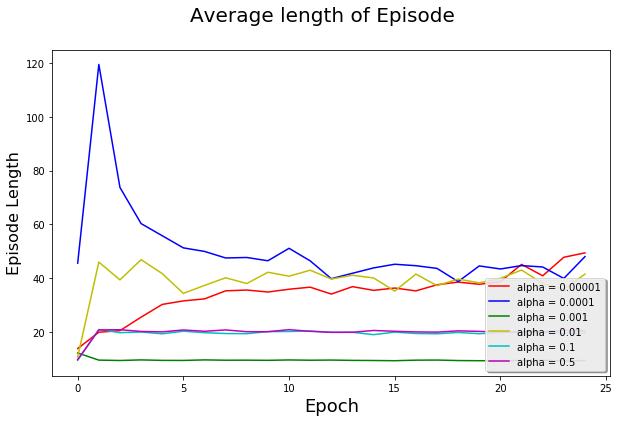

In [11]:
t = np.linspace(0,num-1,num)
colours = ['r','b','g','y','c','m']
labels = ['0.00001','0.0001','0.001','0.01','0.1','0.5']
fig = plt.figure()
for k in range(6):
    #print(i)
    plt.plot(t,saved_data[k*num:(k+1)*num,0],colours[k], label = 'alpha = '+ labels[k]) # plotting t,a separately 

fig.suptitle('Average length of Episode', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Episode Length', fontsize=16)
plt.show()
#fig.savefig('./results/pics/Final_L_Lengths.jpg')

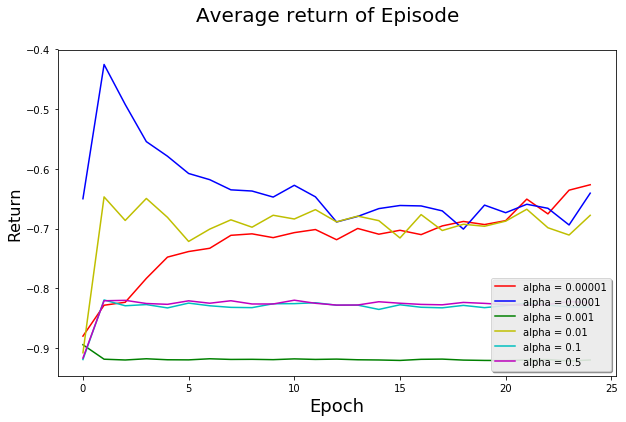

In [12]:
t = np.linspace(0,num-1,num)
colours = ['r','b','g','y','c','m']
labels = ['0.00001','0.0001','0.001','0.01','0.1','0.5']
fig = plt.figure()
for k in range(6):
    #print(i)
    plt.plot(t,saved_data[k*num:(k+1)*num,1],colours[k], label = 'alpha = '+ labels[k]) # plotting t,a separately 

fig.suptitle('Average return of Episode', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Return', fontsize=16)
plt.show()
#fig.savefig('./results/pics/Final_L_Returns.jpg')

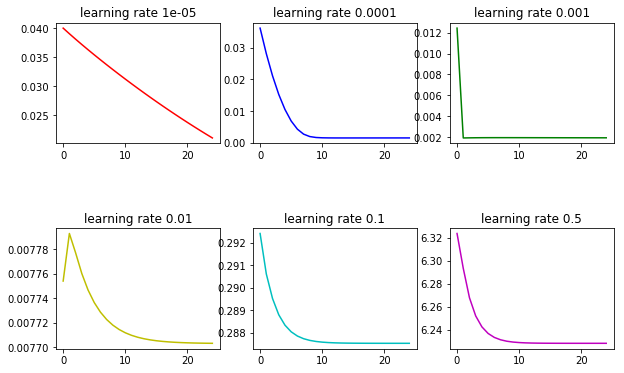

In [13]:
t = np.linspace(0,num-1,num)
colours = ['r','b','g','y','c','m']
labels = ['0.00001','0.0001','0.001','0.01','0.1','0.5']
#fig = plt.figure()
count = 0
f2, axar = plt.subplots(2, 3)

#for k in range(6):
for j in range(2):
    for i in range(3):
            axar[j, i].plot(t,saved_data[count*num:(count+1)*num,2],colours[count])
            axar[j, i].set_title('learning rate {}'.format(alpha_list[count]))
            count+=1

fig.suptitle('Loss of epoch', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)

f2.subplots_adjust(hspace=0.7)
#plt.savefig('./results/pics/Final_L_Loss.png')
plt.show()

# Load Model
Load the model of the best learning rate. Output the Average return and episode length

In [3]:
alpha = 0.00001
file_name = "A3%i.ckpt" %(int(alpha*100000))
save_MDir = 'new_models/A3_i/'
save_model = os.path.join(save_MDir,file_name)
init = tf.global_variables_initializer()
print(save_model)

new_models/A3_i/A31.ckpt


In [4]:
def get_placeholders():
    state = tf.placeholder("float", [None, 4])
    action = tf.placeholder(tf.int32, [None, 2])
    next_state = tf.placeholder("float", [None, 4])
    reward = tf.placeholder("float", [None, 1])
    return state, action, next_state, reward

In [5]:
def test_epoch(sess, test_episodes):   
    episode_length = []
    episode_return = []
    av_len = []
    av_ret = []
    for episode_i in range(test_episodes):
        s = env.reset()
        
        for t in range(300):
            this_q = sess.run(q, feed_dict={state: s.reshape(1, 4)})
            #ac_greedily
            a = np.argmax(this_q)

            s_prime, rwd, done, info = env.step(a)

            if done:
                episode_length.append(t+1)
                episode_return.append(np.power(discount,t)  * -1)
                break
            s = s_prime

    av_len.append(np.mean(np.array(episode_length)))
    av_ret.append(np.mean(np.array(episode_return)))
    return episode_length, episode_return

In [6]:
tf.reset_default_graph()
hidden = 'False'
discount = 0.99
env = gym.make('CartPole-v0')
env._max_episode_steps = 300

state, action, next_state, reward = get_placeholders()
opt, q, loss = create_network(state, action, next_state, reward, hidden, alpha=alpha)
init  = tf.global_variables_initializer()
test_episodes = 1000
"""---------------- restore model after training  --------------------------"""
# restore model and calculate mean length and return over n_test episodes
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init)
    saver.restore(sess = sess, save_path= save_model)
    print("Restored values for learning rate: ",alpha)
    restored_length, restored_return = test_epoch(sess,test_episodes)
    print('The average length of episode is: {} with std: {} '.format(np.mean(restored_length),np.std(restored_length)))
    print('The average return of episode is: {} with std: {} '.format(np.mean(restored_return),np.std(restored_return)))


[2017-04-08 13:44:55,891] Making new env: CartPole-v0


Restored values for learning rate:  1e-05
The average length of episode is: 53.151 with std: 20.622371323395377 
The average return of episode is: -0.6045134327435033 with std: 0.11939713388392649 


1000